<a href="https://colab.research.google.com/github/vinayaksuresh1994/Deepcode/blob/master/ECE570_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')

We are using device name "cuda"


In [ ]:

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.1307,),(0.3081,))])
train_dataset = torchvision.datasets.MNIST('/data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('/data', train=False, download=True, transform=transform)
batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

class CNN(nn.Module): #Define our CNN

  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(7*7*64, 1024)
    self.fc2 = nn.Linear(1024, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(x.shape[0], -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)     
    return x

def train(epoch):
  net.train() # we need to set the mode for our model
  for batch_idx, (images, targets) in enumerate(train_loader):
    optimizer.zero_grad()
    images = images.to(device)
    targets = targets.to(device)
    output = net(images)
    loss = nn.CrossEntropyLoss()(output, targets) # Here is a typical loss function (negative log likelihood)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 200 == 0: # We visulize our output every 20 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')

def test(epoch):
  net.eval() # we need to set the mode for our model
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for images, targets in test_loader:
      images = images.to(device)
      targets = targets.to(device)
      output = net(images)
      correct += (output.max(dim=1)[1] == targets).sum().item()
      test_loss += nn.CrossEntropyLoss()(output, targets).item()*images.shape[0]
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)
  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')

import torch.optim as optim
net = CNN().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.8)
train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 2
for epoch in range(1, max_epoch+1):
  train(epoch)
  test(epoch)


Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw


Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw


Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw




Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Epoch 1: [0/60000] Loss: 2.308778762817383
Epoch 1: [12800/60000] Loss: 0.23580697178840637
Epoch 1: [25600/60000] Loss: 0.08348073810338974
Epoch 1: [38400/60000] Loss: 0.07222231477499008
Epoch 1: [51200/60000] Loss: 0.10725126415491104
Test result on epoch 1: Avg loss is 0.055960509739816186, Accuracy: 98.34%
Epoch 2: [0/60000] Loss: 0.022218359634280205
Epoch 2: [12800/60000] Loss: 0.06040648743510246
Epoch 2: [25600/60000] Loss: 0.08505374193191528
Epoch 2: [38400/60000] Loss: 0.11317206174135208
Epoch 2: [51200/60000] Loss: 0.08503532409667969
Test result on epoch 2: Avg loss is 0.03844061591662466, Accuracy: 98.86%


current batch index is 0
images has shape torch.Size([10, 1, 28, 28])
targets has shape torch.Size([10])


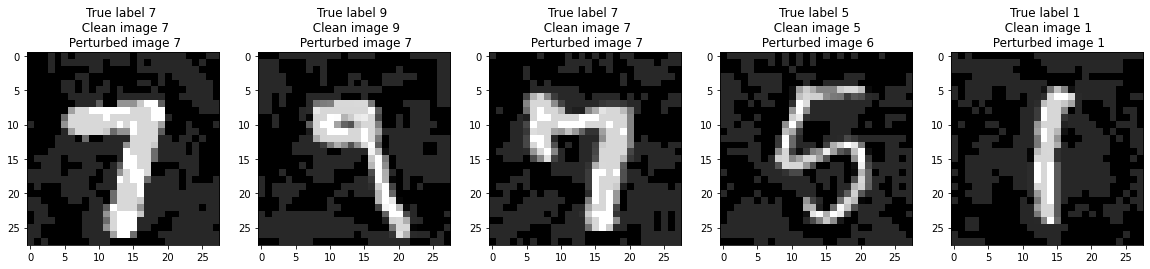

In [ ]:
import matplotlib.pyplot as plt
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)
batch_idx, (images, targets) = next(enumerate(test_loader))
print(f'current batch index is {batch_idx}')
print(f'images has shape {images.size()}')
print(f'targets has shape {targets.size()}')
images = images.to(device)
targets = targets.to(device)
output = net(images)
output_labels = output.max(dim=1)[1] 

def FGSM(net, X, y, epsilon): # Simple Fast Gradient Sign Method
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(net(X + delta), y)
    loss.backward()
    delta_next = epsilon*delta.grad.detach().sign()
    return delta_next

delta = FGSM(net, images, targets, 0.3)
images_corrupted = images + delta
adv_output = net(images_corrupted)
adv_output_labels = adv_output.max(dim=1)[1]


fig, ax = plt.subplots(1,5)
fig.set_size_inches(20,20)
for i in range(5):
    ax[i].imshow(images_corrupted.cpu()[i][0], cmap='gray')
    ax[i].set_title(f'True label {targets[i]} \n  Clean image {output_labels[i]} \n Perturbed image {adv_output_labels[i]}')
fig.show()



In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

def adv_test(): #Test on FGSM perturbed images
  net.eval() # we need to set the mode for our model
  test_loss = 0
  correct = 0
  for images, targets in test_loader:
    images = images.to(device)
    targets = targets.to(device)
    delta = FGSM(net, images, targets, 0.3)
    output = net(images+delta)
    correct += (output.max(dim=1)[1] == targets).sum().item()
  print(f'Accuracy Reduced to: {100.*correct/len(test_loader.dataset)}%')

adv_test()

Accuracy Reduced to: 58.6%


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
def adv_train(epoch):
  rnet.train() # we need to set the mode for our model
  for batch_idx, (images, targets) in enumerate(train_loader):
    images = images.to(device)
    targets = targets.to(device)
    delta = FGSM(rnet, images, targets, 0.3)
    output = rnet(images+delta)
    loss = nn.CrossEntropyLoss()(output, targets) # Here is a typical loss function (negative log likelihood)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 200 == 0: # We visulize our output every 20 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')

import torch.optim as optim
rnet = CNN().to(device) #Robust network
optimizer = optim.SGD(rnet.parameters(), lr=0.01, momentum=0.8)
train_losses = []
train_counter = []
max_epoch = 2
for epoch in range(1, max_epoch+1):
  adv_train(epoch)


Epoch 1: [0/60000] Loss: 2.4040207862854004
Epoch 1: [12800/60000] Loss: 0.4569692313671112
Epoch 1: [25600/60000] Loss: 0.43385985493659973
Epoch 1: [38400/60000] Loss: 0.1466480940580368
Epoch 1: [51200/60000] Loss: 0.1288090944290161
Epoch 2: [0/60000] Loss: 0.2611091136932373
Epoch 2: [12800/60000] Loss: 0.1670135110616684
Epoch 2: [25600/60000] Loss: 0.22304846346378326
Epoch 2: [38400/60000] Loss: 0.19678907096385956
Epoch 2: [51200/60000] Loss: 0.19203083217144012


In [ ]:
def adv_test(): #Test on FGSM perturbed images
  rnet.eval() # we need to set the mode for our model
  test_loss = 0
  correct = 0
  for images, targets in test_loader:
    images = images.to(device)
    targets = targets.to(device)
    delta = FGSM(net, images, targets, 0.3)
    output = rnet(images+delta)
    #output = rnet(images)
    correct += (output.max(dim=1)[1] == targets).sum().item()
  print(f'Accuracy to Adversarial Inputs: {100.*correct/len(test_loader.dataset)}%')

adv_test()

def test_clean(): #Test on Clean images
  rnet.eval() # we need to set the mode for our model
  test_loss = 0
  correct = 0
  for images, targets in test_loader:
    images = images.to(device)
    targets = targets.to(device)
    output = rnet(images)
    #output = rnet(images)
    correct += (output.max(dim=1)[1] == targets).sum().item()
  print(f'Accuracy to Clean Inputs: {100.*correct/len(test_loader.dataset)}%')

test_clean()

Accuracy to Adversarial Inputs: 97.4%
Accuracy to Clean Inputs: 98.82%
